In [ ]:
# schiller test --> iodine that stains different on abnormal cells on cervix
# hinsellman --> coloscopy using scope on cervix
# cytology --> pap smear
# biopsy --> biopsy 
# These indicate the RESULTS of these tests, assuming they were carried out. 1 means suspect screening, 0 means okay screening. 

# dx columns mean previous cervical diagnosis 
# stds_number is the sum over all std columns
# Cant figure out what stds_n_diagnosis is, though. 

In [168]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier

In [ ]:
df = pd.read_csv("./data.csv")

# Encode missings

In [ ]:
df = df.replace({"?": pd.NA})

# Rename columns to be more manageable

In [ ]:
df.columns.values

In [ ]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "(" : "",
    ")" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"

}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values


In [ ]:
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() # convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, but fiddled for an hour and no dice.

# Verifies that the count of stds is the sum over all std columns. 

In [ ]:
all((df[df.columns.values[df.columns.str.startswith("stds_")]].drop(["stds_time_since_first_diagnosis", "stds_time_since_last_diagnosis", "stds_n_diagnosis", "stds_number"], axis = 1).sum(axis = 1) == df.stds_n_diagnosis).dropna())

# Drop n_diagnosis col

In [ ]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

# Check missingness 

In [ ]:
df.isna().mean().sort_values(ascending = False)

# Drop time since std diagnoses

In [ ]:
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

# Check for constant columns

In [ ]:
const = df.nunique() == 1

if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

# Iud/smoking years are always >0 if you have an IUD/smoke.

In [ ]:
df.loc[(df.iud == 1) & (df.iud_years == 0)]

In [ ]:
df.loc[(df.smokes == 1) & (df.smokes_years == 0)]

# PCA on STD Columns

In [ ]:
stds = df[df.columns.values[df.columns.str.startswith("stds_")]].drop("stds_number", axis = 1).dropna()

In [ ]:
scaler = StandardScaler()
pc = PCA()
stds_s = scaler.fit_transform(stds)
pc.fit(stds_s)

In [ ]:
eigs = pc.explained_variance_ratio_
eigs_cum = np.cumsum(eigs)
ind = [i + 1 for i in range(len(eigs))]
print(eigs_cum)

In [ ]:
plt.plot(ind, eigs)
plt.plot(ind, eigs_cum)

In [ ]:
pc.explained_variance_[0:3]

In [ ]:
loadings = pc.components_[0:3].T * np.sqrt(pc.explained_variance_[0:3])

loadmat = pd.DataFrame(np.round(loadings, 4), columns=['PC1', 'PC2', 'PC3'], index=stds.columns.values)
loadmat


In [155]:
x = df.drop(["smokes", "hormonal_bc", "iud", "stds", "schiller", "citology", "biopsy", "hinselmann"], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop(x.columns.values[x.columns.str.startswith("stds")], axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")


In [122]:
x.dtypes

age                           Int64
n_sexual_partners             Int64
first_sexual_intercourse      Int64
n_pregnancies                 Int64
smokes_years                Float64
smokes_packs_year           Float64
hormonal_bc_years           Float64
iud_years                   Float64
dx_cancer                     Int64
dx_cin                        Int64
dx_hpv                        Int64
dx                            Int64
n_stds                        Int64
dtype: object

In [156]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float64')
x[x.columns.values[x.columns.str.startswith("dx")]] = x[x.columns.values[x.columns.str.startswith("dx")]].astype("category")
x.dtypes

age                          float64
n_sexual_partners            float64
first_sexual_intercourse     float64
n_pregnancies                float64
smokes_years                 float64
smokes_packs_year            float64
hormonal_bc_years            float64
iud_years                    float64
dx_cancer                   category
dx_cin                      category
dx_hpv                      category
dx                          category
n_stds                       float64
dtype: object

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [149]:
print(y_train.shape, y_test.shape)
x_train.head()

(643, 1) (215, 1)


,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,dx_cancer,dx_cin,dx_hpv,dx,n_stds
840,24.0,2.0,16.0,3.0,0.0,0.000000,5.00,0.0,0.0,0.0,0.0,0.0,0.0
670,47.0,2.0,17.0,3.0,0.0,0.000000,20.00,0.0,0.0,0.0,0.0,0.0,0.0
845,19.0,2.0,15.0,2.0,0.0,0.000000,0.75,0.0,0.0,0.0,0.0,0.0,0.0
219,23.0,4.0,18.0,1.0,4.0,0.513202,2.00,0.0,0.0,0.0,0.0,0.0,0.0
771,34.0,2.0,16.0,3.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,NaN


In [158]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

pipe = Pipeline([
    ("imputer", mf.ImputationKernel(x_train, mean_match_scheme=mean_match, datasets=1)),
    ("fitter", LGBMClassifier())
])

In [159]:
pipe.fit(x_train, y_train.values.flatten())

Pipeline(steps=[('imputer',
                 
              Class: ImputationKernel
           Datasets: 1
         Iterations: 2
       Data Samples: 643
       Data Columns: 13
  Imputed Variables: 8
save_all_iterations: True),
                ('fitter', LGBMClassifier())])

In [163]:
print(classification_report(y_true = y_test, y_pred = pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       204
           1       0.50      0.09      0.15        11

    accuracy                           0.95       215
   macro avg       0.73      0.54      0.56       215
weighted avg       0.93      0.95      0.93       215



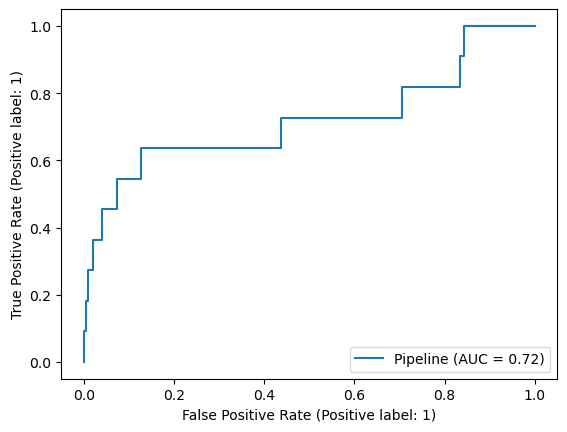

In [167]:
RocCurveDisplay.from_estimator(pipe, x_test, y_test)

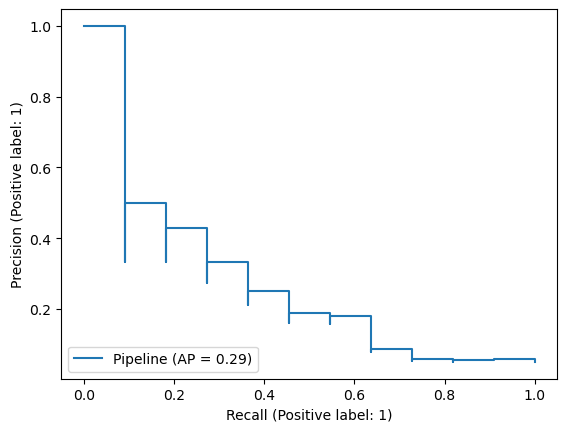

In [169]:
PrecisionRecallDisplay.from_estimator(pipe, x_test, y_test)